In [10]:
using Revise

In [11]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

In [12]:
using Blink

In [13]:
robot = CartPole(add_contacts=false)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(2, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 9715`, ProcessRunning), TCPSocket(RawFD(54) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(2, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(58) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 2, Nullable{Any}(true))))

In [14]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params)
net, loss = LearningMPC.mimic_net([4, 24, 24, 1]; regularization=1e-6)
optimizer = Flux.ADAM(Flux.params(net); decay=1e-8)

net_controller = let net = net
    function (τ, t, x)
        τ .= Flux.Tracker.data(net(LearningMPC.qv(x)))
    end
end

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_controller]);

Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [15]:
sample_sink = LearningMPC.MPCSampleSink(keep_nulls=false; lqrsol=lqrsol, 
    lqr_warmstart_index=1,
    learned_warmstart_index=2)

playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.multiplex!(
    sample_sink,
    playback_sink
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.multiplex!(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_controller),
    live_viewer
    )

collect_into! = let x_init = nominal_state(robot), x0 = MechanismState{Float64}(robot.mechanism), sink = sample_sink
    function (data::Vector{<:LearningMPC.Sample}, σv)
        empty!(sink)
        LearningMPC.randomize!(x0, x_init, 0.5, σv)
        results = LCPSim.simulate(x0, 
            dagger_controller,
            robot.environment, params.Δt, 100, 
            params.lcp_solver;
            termination=x -> !(-π/4 <= configuration(x)[2] <= π/4))
        append!(data, sink.samples)
    end
end

(::#23) (generic function with 1 method)

In [16]:
library_file = "library-mimic.jld2"
dataset_file = "cartpole-mimic.jld2"

"cartpole-mimic.jld2"

In [17]:
if isfile(library_file)
    all_training_data, all_validation_data = jldopen(library_file) do file
        file["training"], file["testing"]
    end
else
    all_training_data = Vector{Tuple{eltype(sample_sink.samples)}}()
    all_validation_data = Vector{Tuple{eltype(sample_sink.samples)}}()
end;

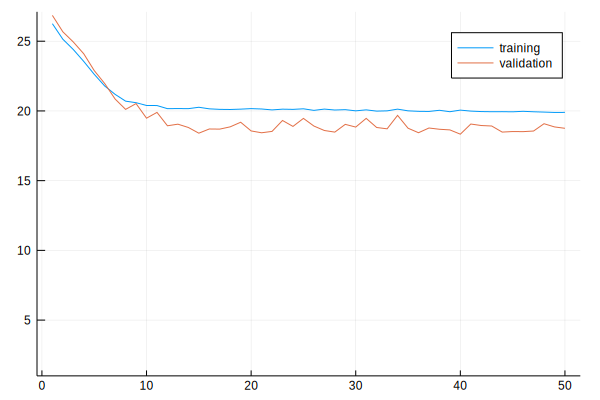

 11.231871 seconds (26.75 M allocations: 1.796 GiB, 6.95% gc time)


Progress:  10%|████                                     |  ETA: 0:22:27

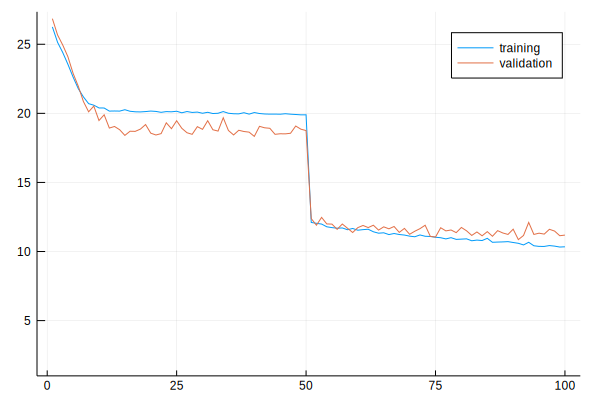

 28.620449 seconds (93.96 M allocations: 6.441 GiB, 9.02% gc time)


Progress:  20%|████████                                 |  ETA: 0:21:38

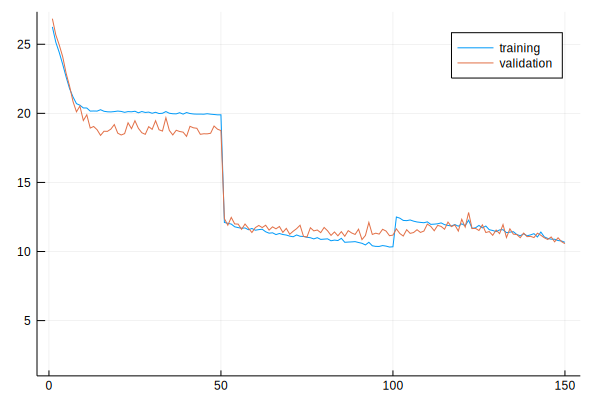

 48.719581 seconds (163.11 M allocations: 11.181 GiB, 9.28% gc time)


Progress:  30%|████████████                             |  ETA: 0:24:43

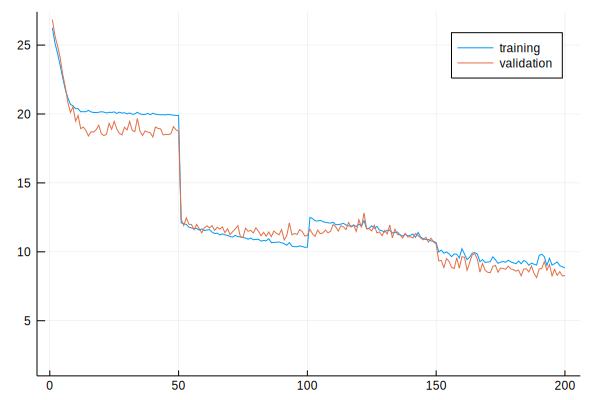

 70.027764 seconds (232.25 M allocations: 15.920 GiB, 9.50% gc time)


Progress:  40%|████████████████                         |  ETA: 0:21:57

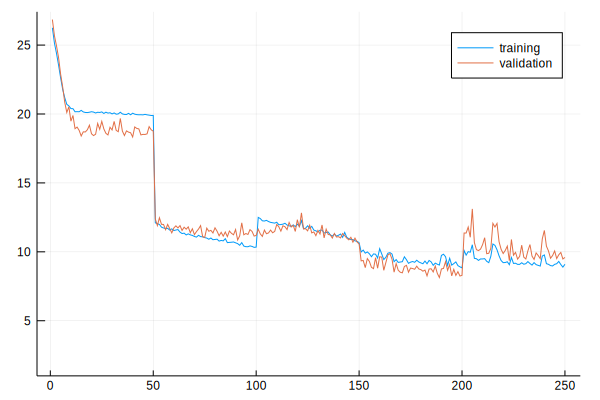

 78.316762 seconds (258.14 M allocations: 17.694 GiB, 9.74% gc time)


Progress:  50%|████████████████████                     |  ETA: 0:16:33

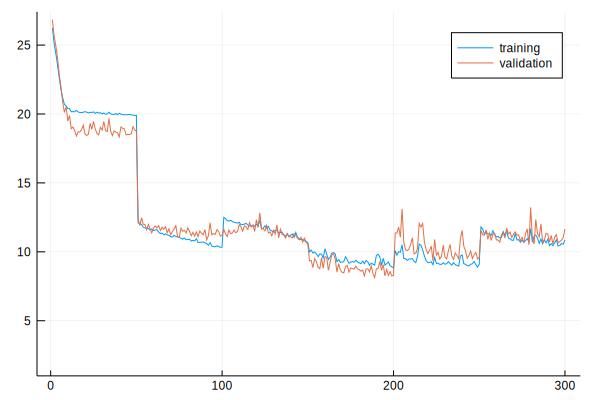

103.768516 seconds (327.28 M allocations: 22.434 GiB, 9.87% gc time)


Progress:  60%|█████████████████████████                |  ETA: 0:15:04

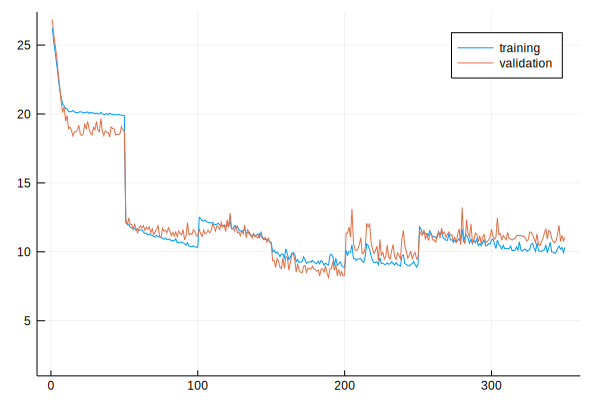

118.901080 seconds (374.80 M allocations: 25.691 GiB, 9.92% gc time)


Progress:  70%|█████████████████████████████            |  ETA: 0:11:24

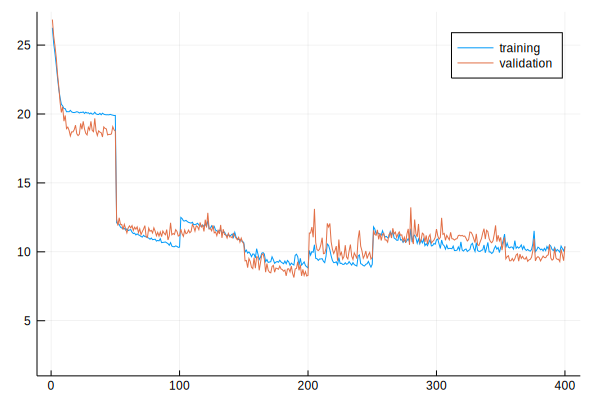

142.596589 seconds (443.94 M allocations: 30.430 GiB, 10.01% gc time)


Progress:  80%|█████████████████████████████████        |  ETA: 0:07:45

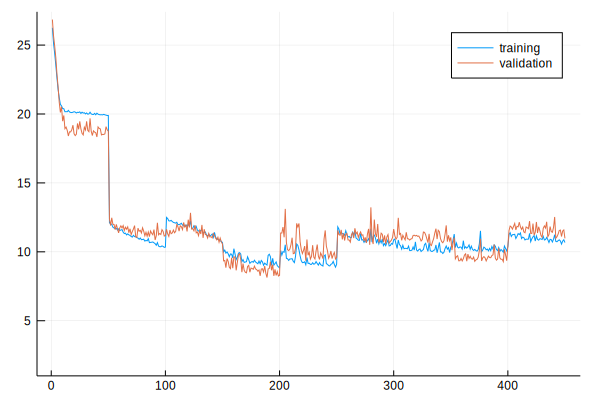

160.170604 seconds (513.09 M allocations: 35.170 GiB, 9.61% gc time)


Progress:  90%|█████████████████████████████████████    |  ETA: 0:03:59

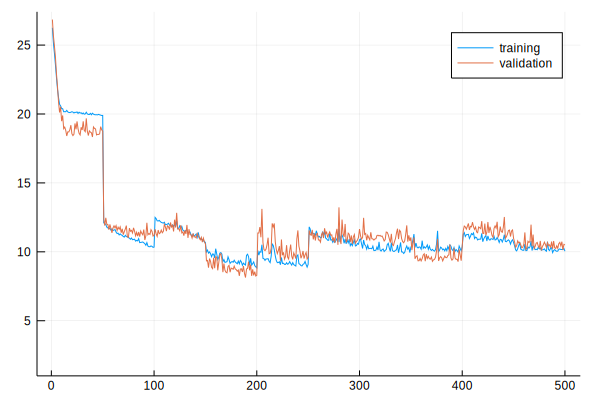

176.620201 seconds (559.45 M allocations: 38.348 GiB, 9.60% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:40:01


In [18]:
function mirror(s::S) where {S <: LearningMPC.Sample}
    S(-1 .* s.state,
      -1 .* s.input,
      s.x0,
      s.u0,
      s.warmstart_costs,
      s.mip)
end

datasets = Vector{LearningMPC.Dataset{Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 10
σv = 5.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    collect_into!(dataset.training_data, σv)
    collect_into!(dataset.training_data, 0.1 * σv)
    collect_into!(dataset.training_data, 0.01 * σv)
    
    filter!(dataset.training_data) do sample
        all(isfinite, sample.input)
    end

    
    new_samples = tuple.(dataset.training_data)
    if !isempty(new_samples)
        new_training, new_validation = splitobs(shuffleobs(new_samples); at=0.8)
        append!(all_training_data, new_training)
        append!(all_validation_data, new_validation)
        
        # The cart-pole system is symmetric, so for every sample with state x and input u,
        # we can sythesize an example with state -x and input -u with the same cost bounds
        append!(all_training_data, tuple.(mirror.(first.(new_training))))
        
        # The cart-pole system is symmetric, so for every sample with state x and input u,
        # we can sythesize an example with state -x and input -u with the same cost bounds
        append!(all_validation_data, tuple.(mirror.(first.(new_validation))))
    end

    @time for i in 1:50
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen(dataset_file, "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt, 
            "horizon" => params.horizon,
        )
        file["losses"] = losses
    end
    
    jldopen(library_file, "w") do file
        file["training"] = all_training_data
        file["testing"] = all_validation_data
    end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (1, ylims(plt)[2]))
    display(plt)

end